DATA UNDERSTANDING AND CLEANING.

In [3]:
import pandas as pd

# Load 
df = pd.read_csv(r'C:\Users\dandu\Downloads\playground-series-s4e1\train.csv')  


# Overview
print(df.shape)
print(df.dtypes)

# Separate into categories
id_cols = ["id", "CustomerId", "Surname"]
target_col = "Exited"
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop(id_cols + [target_col], errors="ignore").tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)
print("ID columns:", id_cols)


(165034, 14)
id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object
Numerical columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical columns: ['Surname', 'Geography', 'Gender']
ID columns: ['id', 'CustomerId', 'Surname']


In [4]:
# Duplicate rows
print("Duplicate rows:", df.duplicated().sum())

# Missing values
print("Missing values:\n", df.isnull().sum())

# Weird characters in text
for col in cat_cols + ["Surname"]:
    print(f"Unique samples from {col}:")
    print(df[col].dropna().unique()[:20])  # show first 20 unique values


Duplicate rows: 0
Missing values:
 id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
Unique samples from Surname:
['Okwudilichukwu' 'Okwudiliolisa' 'Hsueh' 'Kao' 'Chiemenam' 'Genovese'
 "Ch'ang" 'Chukwuebuka' 'Manna' 'Cattaneo' 'Fokine' 'Chiu' 'Rossi' "Ts'ai"
 'Chukwuemeka' 'Tung' 'Macdonald' 'Esquivel' 'Hargreaves' "Ts'ui"]
Unique samples from Geography:
['France' 'Spain' 'Germany']
Unique samples from Gender:
['Male' 'Female']
Unique samples from Surname:
['Okwudilichukwu' 'Okwudiliolisa' 'Hsueh' 'Kao' 'Chiemenam' 'Genovese'
 "Ch'ang" 'Chukwuebuka' 'Manna' 'Cattaneo' 'Fokine' 'Chiu' 'Rossi' "Ts'ai"
 'Chukwuemeka' 'Tung' 'Macdonald' 'Esquivel' 'Hargreaves' "Ts'ui"]


In [5]:
# Summary stats
print(df[num_cols].describe().T)

# Simple sanity checks
print("CreditScore range:", df["CreditScore"].min(), "-", df["CreditScore"].max())
print("Age range:", df["Age"].min(), "-", df["Age"].max())
print("Balance range:", df["Balance"].min(), "-", df["Balance"].max())
print("EstimatedSalary range:", df["EstimatedSalary"].min(), "-", df["EstimatedSalary"].max())


                    count           mean           std     min       25%  \
CreditScore      165034.0     656.454373     80.103340  350.00    597.00   
Age              165034.0      38.125888      8.867205   18.00     32.00   
Tenure           165034.0       5.020353      2.806159    0.00      3.00   
Balance          165034.0   55478.086689  62817.663278    0.00      0.00   
NumOfProducts    165034.0       1.554455      0.547154    1.00      1.00   
HasCrCard        165034.0       0.753954      0.430707    0.00      1.00   
IsActiveMember   165034.0       0.497770      0.499997    0.00      0.00   
EstimatedSalary  165034.0  112574.822734  50292.865585   11.58  74637.57   

                      50%          75%        max  
CreditScore         659.0     710.0000     850.00  
Age                  37.0      42.0000      92.00  
Tenure                5.0       7.0000      10.00  
Balance               0.0  119939.5175  250898.09  
NumOfProducts         2.0       2.0000       4.00  
Has

In [6]:
# keep id and Surname this time
df_clean = df.copy()  


In [7]:
# List of categorical columns
cat_cols = ['Surname', 'Geography', 'Gender']

# Normalize categorical columns except Surname
for col in cat_cols:
    if col != "Surname":
        df_clean[col] = df_clean[col].str.strip().str.lower()

# Check unique counts after normalization
print(df_clean[cat_cols].nunique())
print(df_clean[cat_cols].head())


Surname      2797
Geography       3
Gender          2
dtype: int64
          Surname Geography Gender
0  Okwudilichukwu    france   male
1   Okwudiliolisa    france   male
2           Hsueh    france   male
3             Kao    france   male
4       Chiemenam     spain   male


In [8]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

df_clean[num_cols] = num_imputer.fit_transform(df_clean[num_cols])
df_clean[cat_cols] = cat_imputer.fit_transform(df_clean[cat_cols])


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])


Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64


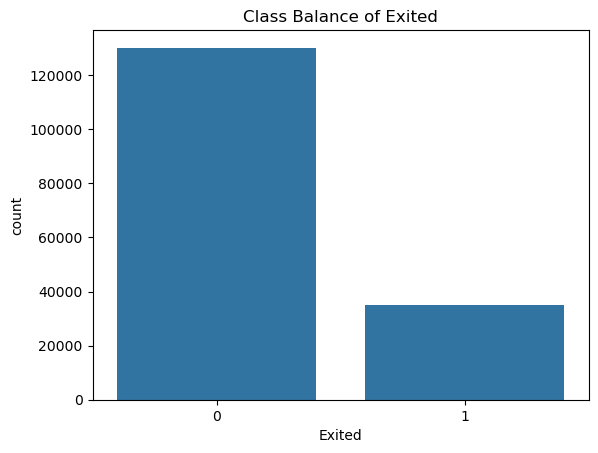

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df_clean["Exited"].value_counts(normalize=True))

sns.countplot(x="Exited", data=df_clean)
plt.title("Class Balance of Exited")
plt.show()


Interpretation :                               
This is a moderately imbalanced dataset (roughly 80/20).                              
Accuracy alone is misleading → a dumb model that predicts “0” for everyone would already hit ~79% accuracy.

LETS USE :                                                                                                              
AUC-ROC (how well the model separates classes).                              
PR-AUC (important for imbalanced data).                    
Threshold tuning (not default 0.5) to balance precision vs recall depending on business need.

✅ Milestone 1 Recap (your dataset status)                                                   
Columns inventoried — ✔️                               
No duplicates, no missing values — ✔️                           
Ranges OK (CreditScore 350–850, Age 18–92, Balance up to ~250k, Salary up to ~200k) — ✔️                               
Keeping id and Surname (just don’t use them as model features) — ✔️                                     
Categorical normalization done (only Geography + Gender) — ✔️                         
Missing values — not an issue, but pipeline will still handle them for safety — ✔️                          
Preprocessing pipeline (scaler + encoder + imputers) defined — ⚡ next step to finalize                         
Class balance check — ~80/20 → treat as imbalanced classification — ✔️                                   


In [11]:
import pandas as pd

# 1️⃣ Save cleaned dataset
df_clean.to_csv("bank_churn_cleaned.csv", index=False)
print("Cleaned dataset saved as bank_churn_cleaned.csv")

# 2️⃣ Create data dictionary
data_dict = {
    "Column": ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
               'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'],
    "Type": ['int64', 'int64', 'object', 'int64', 'object', 'object', 'float64', 'int64', 'float64',
             'int64', 'float64', 'float64', 'float64', 'int64'],
    "Description": ['Row identifier', 'Customer identifier', 'Customer surname', 'Customer credit score',
                    'Customer country', 'Gender (Male/Female)', 'Customer age', 'Years with bank', 'Account balance',
                    'Number of bank products', 'Binary flag for credit card', 'Binary flag for active membership',
                    'Estimated annual salary', 'Target: 1=churned, 0=not churned'],
    "Notes / Cleaning": ['Kept, not used for modeling',
                         'Kept for mapping predictions; multiple rows per customer',
                         'Preserved as-is; not used for modeling',
                         'Range 350–850, no missing',
                         'Normalized to lowercase, stripped whitespace',
                         'Normalized to lowercase, stripped whitespace',
                         'Range 18–92, no missing',
                         'Range 0–10',
                         'Range 0–250,898; 0 included; scaled later in pipeline',
                         'Range 1–4',
                         '0/1',
                         '0/1',
                         'Range 11.58–199,992; scaled later',
                         'Class balance 0=78.8%, 1=21.2%']
}

data_dict_df = pd.DataFrame(data_dict)

# 3️⃣ Save data dictionary as Excel
data_dict_df.to_excel("bank_churn_data_dictionary.xlsx", index=False)
print("Data dictionary saved as bank_churn_data_dictionary.xlsx")


Cleaned dataset saved as bank_churn_cleaned.csv
Data dictionary saved as bank_churn_data_dictionary.xlsx


In [12]:
from ydata_profiling import ProfileReport

# Use your cleaned dataset
profile = ProfileReport(
    df_clean,
    title="Bank Customer Churn - Data Quality Report",
    minimal=False,  # set True for a simpler report
    explorative=True
)

# Export as HTML
profile.to_file("bank_churn_data_quality_report.html")

# Export as PDF
profile.to_file("bank_churn_data_quality_report.pdf")


C:\Users\dandu\anaconda3\envs\airfly\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s]
C:\Users\dandu\anaconda3\envs\airfly\Lib\site-packages\ydata_profiling\profile_report.py:386: UserWarning: Extension .pdf not supported. For now we assume .html was intended. To remove this warning, please use .html or .json.
  warnings.warn(
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 32.72it/s]


Pandas Profiling (ydata - profiling) report ✔️     
Feature Dictionary DONE                                
Cleaned Dataset DONE                            
Preprocessing Pipeline (useful for now and in case of new addition) DONE

EDA - EXPLORATORY DATA ANALYSIS.

Univariate Analysis

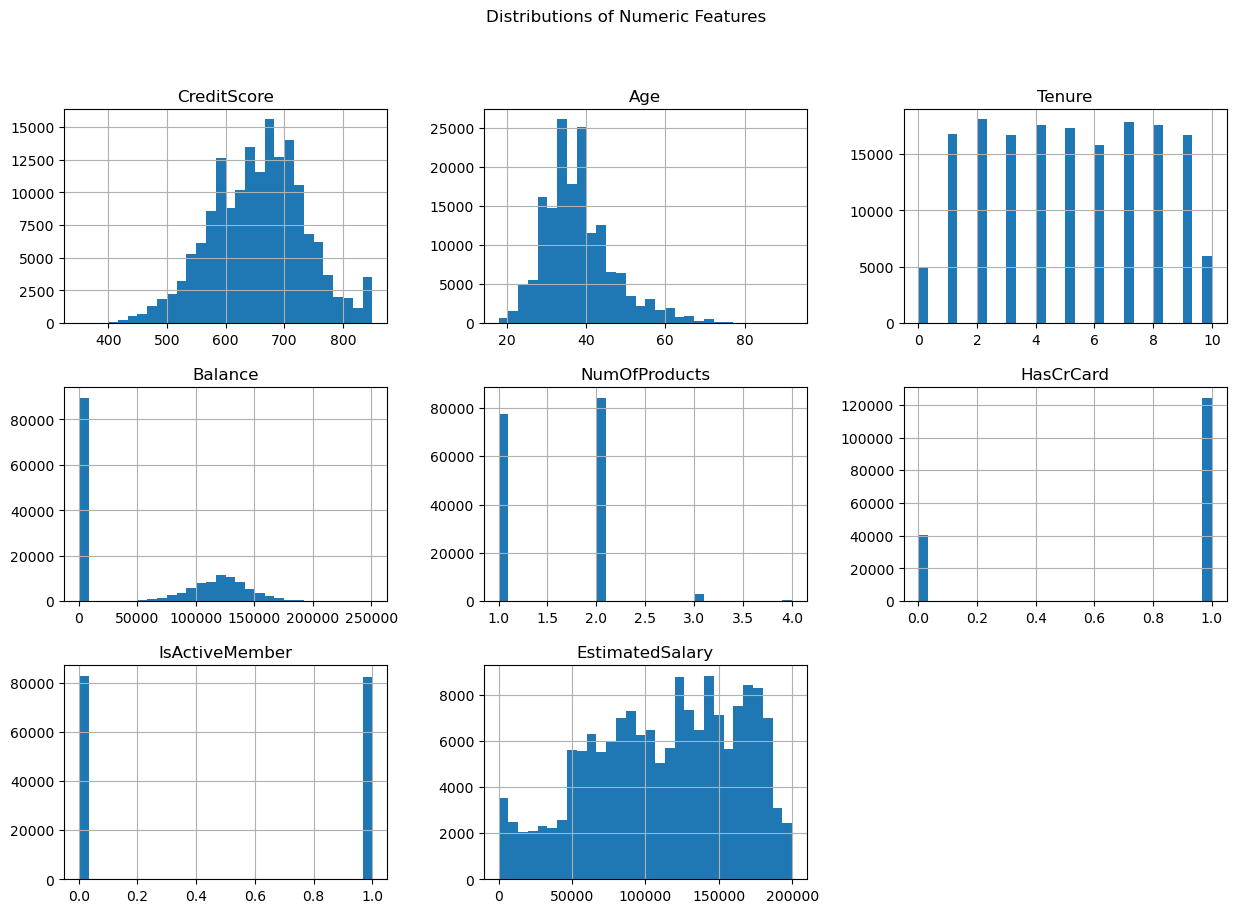

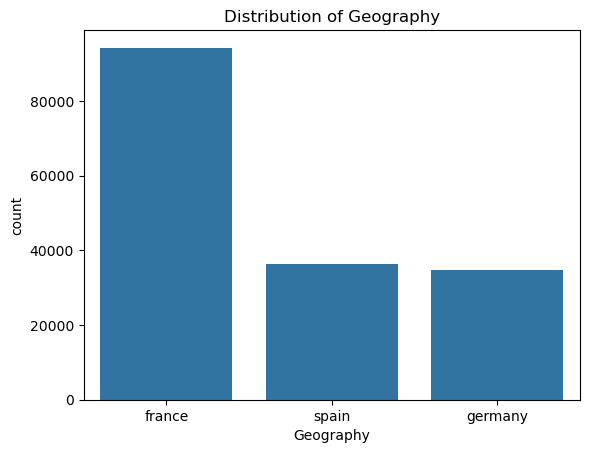

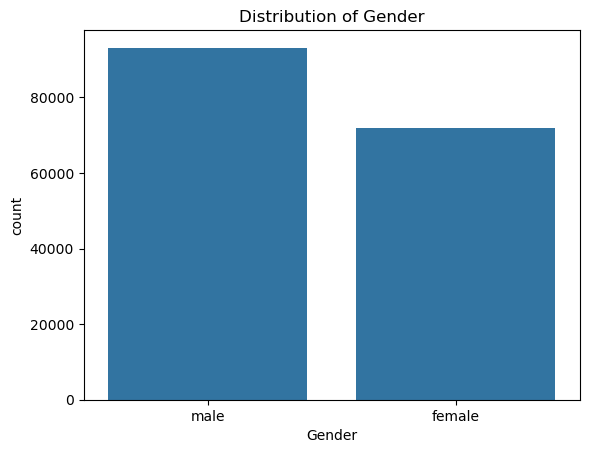

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numeric features
df_clean[num_cols].hist(bins=30, figsize=(15,10))
plt.suptitle("Distributions of Numeric Features")
plt.show()

# Countplots for categorical features
for col in ["Geography", "Gender"]:
    sns.countplot(x=col, data=df_clean)
    plt.title(f"Distribution of {col}")
    plt.show()



Churn rate by Geography:
 Geography
germany    0.378952
spain      0.172176
france     0.165282
Name: Exited, dtype: float64


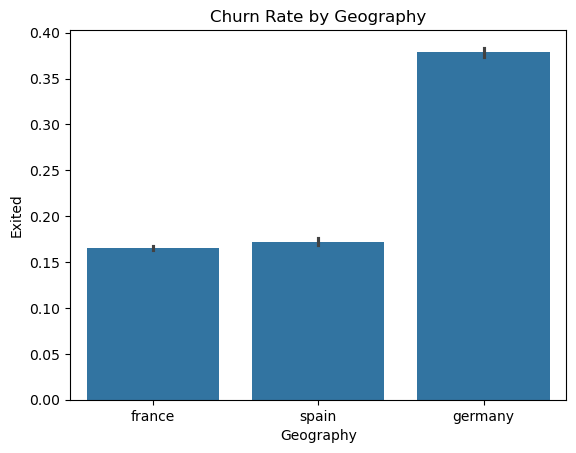


Churn rate by Gender:
 Gender
female    0.279687
male      0.159055
Name: Exited, dtype: float64


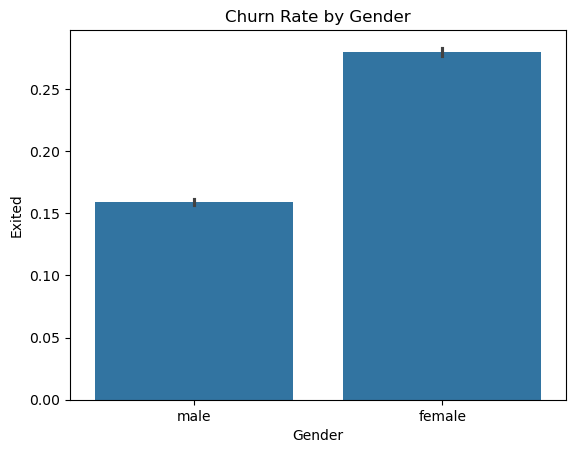


Churn rate by NumOfProducts:
 NumOfProducts
3.0    0.882516
4.0    0.875789
1.0    0.347119
2.0    0.060422
Name: Exited, dtype: float64


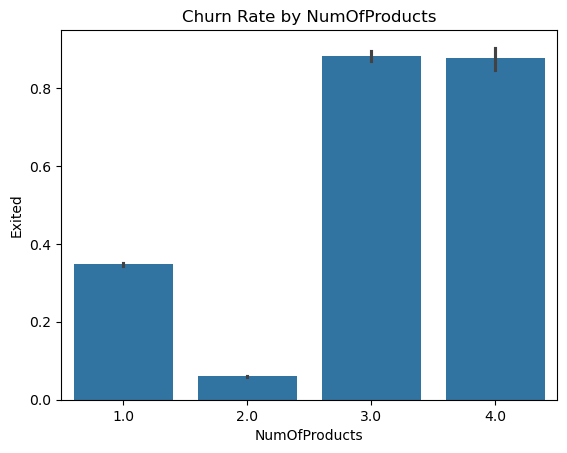


Churn rate by HasCrCard:
 HasCrCard
0.0    0.227429
1.0    0.206433
Name: Exited, dtype: float64


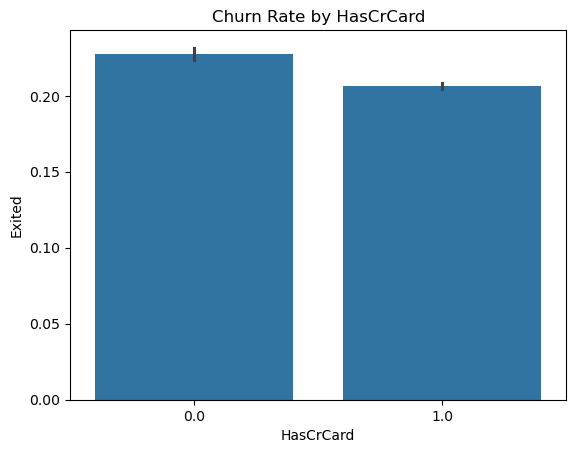


Churn rate by IsActiveMember:
 IsActiveMember
0.0    0.297086
1.0    0.125345
Name: Exited, dtype: float64


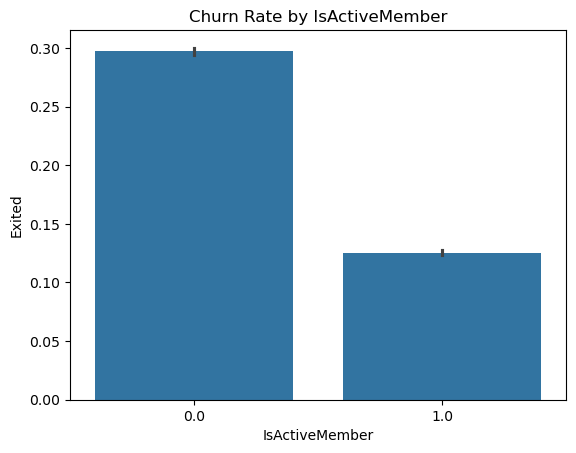

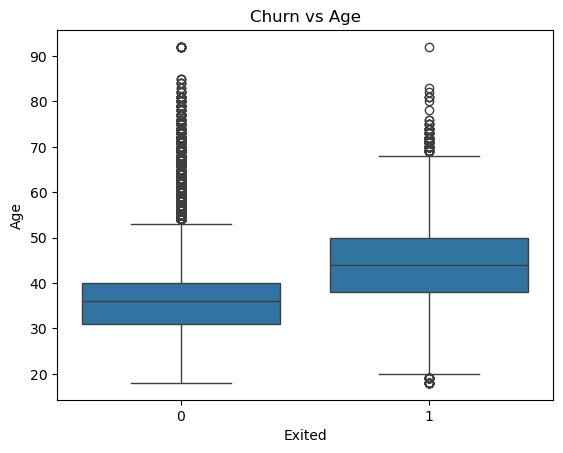

In [14]:
# Churn rate by categorical variables
for col in ["Geography", "Gender", "NumOfProducts", "HasCrCard", "IsActiveMember"]:
    churn_rate = df_clean.groupby(col)["Exited"].mean().sort_values(ascending=False)
    print(f"\nChurn rate by {col}:\n", churn_rate)
    sns.barplot(x=col, y="Exited", data=df_clean)
    plt.title(f"Churn Rate by {col}")
    plt.show()

# Churn rate across age
sns.boxplot(x="Exited", y="Age", data=df_clean)
plt.title("Churn vs Age")
plt.show()


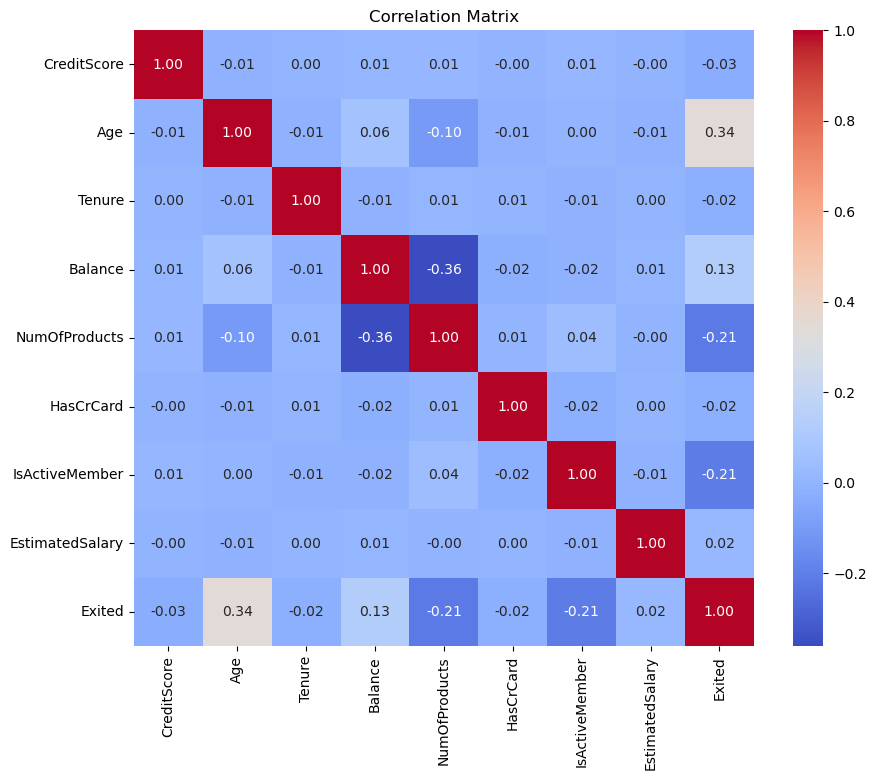

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(df_clean[num_cols + ["Exited"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [16]:
# Age groups
df_clean["AgeGroup"] = pd.cut(df_clean["Age"], bins=[18,30,40,50,60,100], labels=["18-30","31-40","41-50","51-60","60+"])

# Credit score buckets
df_clean["CreditBucket"] = pd.cut(df_clean["CreditScore"], bins=[300,580,670,740,800,850], labels=["Poor","Fair","Good","VeryGood","Excellent"])

# Tenure buckets
df_clean["TenureGroup"] = pd.cut(df_clean["Tenure"], bins=[0,2,5,10], labels=["0-2","3-5","6-10"])


In [17]:
df_clean["BalanceSalaryRatio"] = df_clean["Balance"] / (df_clean["EstimatedSalary"] + 1)  # avoid div by zero
df_clean["Products_Card"] = df_clean["NumOfProducts"] * df_clean["HasCrCard"]
df_clean["AgeTenure"] = df_clean["Age"] * df_clean["Tenure"]


In [18]:
df_clean["HighBalance"] = (df_clean["Balance"] > df_clean["Balance"].median()).astype(int)
df_clean["HighSalary"] = (df_clean["EstimatedSalary"] > df_clean["EstimatedSalary"].median()).astype(int)
df_clean["DormantCustomer"] = ((df_clean["IsActiveMember"]==0) & (df_clean["Balance"]==0)).astype(int)
df_clean["ZeroBalance"] = (df_clean["Balance"]==0).astype(int)
df_clean["LongTenureLowProducts"] = ((df_clean["Tenure"]>7) & (df_clean["NumOfProducts"]==1)).astype(int)


In [19]:
import numpy as np

# Check skewness
print(df_clean[num_cols].skew())

# Apply log transformation for highly skewed (Balance, EstimatedSalary)
df_clean["LogBalance"] = np.log1p(df_clean["Balance"])  # log(1+x)
df_clean["LogSalary"] = np.log1p(df_clean["EstimatedSalary"])


CreditScore       -0.059291
Age                0.968063
Tenure             0.006490
Balance            0.382020
NumOfProducts      0.368278
HasCrCard         -1.179255
IsActiveMember     0.008920
EstimatedSalary   -0.309022
dtype: float64


In [20]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

X = df_clean.drop(columns=["Exited", "CustomerId"])  # keep CustomerId for mapping only
y = df_clean["Exited"]

# Mutual Information
mi_scores = mutual_info_classif(X.select_dtypes(include=["int64","float64"]), y)
mi_results = pd.Series(mi_scores, index=X.select_dtypes(include=["int64","float64"]).columns).sort_values(ascending=False)
print("Mutual Information scores:\n", mi_results.head(15))

# Random Forest importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_num = X.select_dtypes(include=["int64", "float64"]).fillna(0)
rf.fit(X_num, y)
importances = pd.Series(rf.feature_importances_, index=X.select_dtypes(include=["int64","float64"]).columns).sort_values(ascending=False)
print("Random Forest Feature Importances:\n", importances.head(15))


Mutual Information scores:
 NumOfProducts         0.099907
Age                   0.083097
Products_Card         0.081227
AgeTenure             0.046792
IsActiveMember        0.042316
HasCrCard             0.022674
Balance               0.014851
LogBalance            0.014563
BalanceSalaryRatio    0.010654
LogSalary             0.007786
EstimatedSalary       0.006552
CreditScore           0.005353
Tenure                0.004988
id                    0.000000
dtype: float64
Random Forest Feature Importances:
 Age                   0.177777
NumOfProducts         0.100951
id                    0.096073
CreditScore           0.089657
EstimatedSalary       0.086630
LogSalary             0.086389
AgeTenure             0.072964
Products_Card         0.052714
LogBalance            0.051160
Balance               0.050778
BalanceSalaryRatio    0.049404
IsActiveMember        0.045743
Tenure                0.033442
HasCrCard             0.006319
dtype: float64


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np

# ------------------------- SPLIT DATA -------------------------
X = df_clean.drop("Exited", axis=1)
y = df_clean["Exited"]

# Drop high-cardinality / ID-like columns
high_card_cols = ["CustomerId", "RowNumber", "Surname"]
X = X.drop(columns=high_card_cols, errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ------------------ FIX: ONE-HOT ENCODE (SPARSE) ------------------
cat_cols = X_train.select_dtypes(include=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=True, handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", X_train.select_dtypes(include=["number"]).columns)
    ]
)

# Transform the data
X_train_enc = preprocess.fit_transform(X_train)
X_test_enc = preprocess.transform(X_test)

# ------------------------- MODELS -------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

results = []

# ------------------------- TRAIN & EVALUATE -------------------------
for name, model in models.items():
    print(f"Training model: {name} ...")
    
    model.fit(X_train_enc, y_train)
    y_pred = model.predict(X_test_enc)
    y_proba = model.predict_proba(X_test_enc)[:,1]

    print(f"Finished {name}")

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_proba)
    })

# ------------------------- RESULTS -------------------------
results_df = pd.DataFrame(results).sort_values(by="AUC-ROC", ascending=False)
print(results_df)


Training model: Logistic Regression ...


C:\Users\dandu\anaconda3\envs\airfly\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Finished Logistic Regression
Training model: Decision Tree ...
Finished Decision Tree
Training model: Random Forest ...
Finished Random Forest
Training model: Gradient Boosting ...
Finished Gradient Boosting
Training model: XGBoost ...


C:\Users\dandu\anaconda3\envs\airfly\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:24:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished XGBoost
Training model: LightGBM ...
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2149
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304


C:\Users\dandu\anaconda3\envs\airfly\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\dandu\anaconda3\envs\airfly\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Finished LightGBM
Training model: CatBoost ...
Finished CatBoost
                 Model  Accuracy  Precision    Recall        F1   AUC-ROC
5             LightGBM  0.865665   0.745759  0.553981  0.635721  0.889437
3    Gradient Boosting  0.864877   0.757656  0.531357  0.624642  0.888712
6             CatBoost  0.865241   0.750000  0.544674  0.631055  0.888240
4              XGBoost  0.863665   0.736932  0.553121  0.631932  0.886330
2        Random Forest  0.860514   0.736299  0.530928  0.616972  0.877559
0  Logistic Regression  0.741206   0.431703  0.705040  0.535508  0.787856
1        Decision Tree  0.801103   0.529045  0.546392  0.537578  0.707927


In [22]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from scipy import sparse

# Base models
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
lgb_model = LGBMClassifier(random_state=42)
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# Stacking ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('cat', cat_model)
    ],
    final_estimator=LogisticRegression(max_iter=500),
    stack_method='predict_proba',
    n_jobs=-1,
    cv=5
)

# ---- FIX: Convert sparse to dense SAFELY (only if needed) ----
if sparse.issparse(X_train_enc):
    X_train_stack = X_train_enc.toarray()
else:
    X_train_stack = X_train_enc

if sparse.issparse(X_test_enc):
    X_test_stack = X_test_enc.toarray()
else:
    X_test_stack = X_test_enc

print("Training Stacking Ensemble...")

stacking_model.fit(X_train_stack, y_train)

print("Evaluating Ensemble...")

y_pred = stacking_model.predict(X_test_stack)
y_proba = stacking_model.predict_proba(X_test_stack)[:,1]

# Metrics
ensemble_results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_proba)
}

print("\n🔶 Ensemble Performance:")
for k, v in ensemble_results.items():
    print(f"{k}: {v:.4f}")


Training Stacking Ensemble...
Evaluating Ensemble...


C:\Users\dandu\anaconda3\envs\airfly\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\dandu\anaconda3\envs\airfly\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔶 Ensemble Performance:
Accuracy: 0.8655
Precision: 0.7492
Recall: 0.5480
F1: 0.6330
AUC-ROC: 0.8897
